In [1]:
#load metadata for all (secondary) outputs available for this project
import os
import json
objs = []
for entry in os.scandir("input/meta"):
    with open(entry.path, "r") as f:
        obj = json.loads(f.read())
        
    if obj["removed"] != True:
        objs.append(obj)

#load participants columns/info (for phenotype - if you have it defined for your project)
with open("input/participants.json") as f:
    participants = json.load(f)
    
with open("input/participants_column.json") as f:
    participants_column = json.load(f)

In [2]:
# EDIT ME
# Now you need to pick and choose which objects # you want to load 
# into this notebook to perform your data analysis.
#
# Itereate through the objs list from above step and pick the objects you need.
# The actual file path for each object is stored in obj["_secondaryPath"]

# import any library you need to load data (for csv, pandas works nicely)
import pandas
import numpy as np
# you probably need to create multiple lists to load various things
myCSVs = {}
sub_list = []
for obj in objs:
    #put whatever the condition you'd like to use
    #if you don't know which field/keys to use, just
    #open up one of the .json under input/meta directory
    #and see what key/values exists
    if obj["datatype"]["name"] == "neuro/tractmeasures":
        if obj["datatype_tags"][0] == "profiles":
            if "act" in obj["tags"]:
                subject = obj["meta"]["subject"]
                #construct the filepath based on the datatype of your choice 
                #(see https://brainlife.io/datatypes pages for more information)
                csvPath = "input/"+obj["_secondaryPath"]+"/tractmeasures.csv"
                #load the data into this notebook. you can use pandas/nibabel/etc..
                myCSVs[subject] = pandas.read_csv(csvPath)
                sub_list.append(subject)

In [3]:
import pandas as pd
rtp = pd.read_csv("rtp_acute_cases.csv",index_col=0)
#load any subject to get the list of tracts
df = myCSVs[subject]
tract_name_list_sorted = df['structureID'].unique()

In [4]:
metric = 'fa'
n_nodes = 100
n_tracts = len(tract_name_list_sorted)
fa_profiles = np.zeros((n_tracts, n_nodes, len(sub_list)))

In [5]:
#profiles after QSIPrep
for s, sub in enumerate(sub_list):
    df = myCSVs[sub]
    for t, tract_name in enumerate(tract_name_list_sorted):
        #select only the block related to the current tract
        row_start = t*n_nodes
        row_end = t*n_nodes + n_nodes
        current_block = df.iloc[row_start:row_end]
        current_profile = current_block[metric]
        fa_profiles[t,:,s] = current_profile

In [6]:
#remove the Cerebellar tracts
tmp = []
idx_to_keep = []
for t, tract_name in enumerate(tract_name_list_sorted):
    if "Cerebellar" in tract_name:
        print("removing %s from the tract list" %tract_name)
    else:
        tmp.append(tract_name)
        idx_to_keep.append(t)
tract_name_list_sorted = tmp
fa_profiles = fa_profiles[idx_to_keep,:,:]
n_tracts = len(tract_name_list_sorted)
print("Number of remaining tracts: %i" %len(tract_name_list_sorted))

removing leftAnterioFrontoCerebellar from the tract list
removing leftContraAnterioFrontoCerebellar from the tract list
removing leftContraMotorCerebellar from the tract list
removing leftMotorCerebellar from the tract list
removing leftOccipitoCerebellar from the tract list
removing leftParietoCerebellar from the tract list
removing leftThalamicoCerebellar from the tract list
removing rightAnterioFrontoCerebellar from the tract list
removing rightContraAnterioFrontoCerebellar from the tract list
removing rightContraMotorCerebellar from the tract list
removing rightMotorCerebellar from the tract list
removing rightOccipitoCerebellar from the tract list
removing rightParietoCerebellar from the tract list
removing rightThalamicoCerebellar from the tract list
Number of remaining tracts: 47


In [7]:
def orient_profiles(profiles2D):
    #reorient the profiles so that they have the
    #same orientation as the first profile
    oriented_profiles = np.zeros(profiles2D.shape)
    ref_profile = profiles2D[0,:] #reference
    oriented_profiles[0,:] = ref_profile
    flip_count=0
    for p, profile in enumerate(profiles2D[1:]):
        d1 = np.linalg.norm(ref_profile - profile)
        d2 = np.linalg.norm(ref_profile - np.flip(profile))
        if d2 < d1:
            oriented_profiles[p+1,:] = np.flip(profile)
            flip_count+=1
        else:
            oriented_profiles[p+1,:] = profile      
    return oriented_profiles

In [8]:
#reorient profiles (once for all)
fa_profiles_oriented = np.zeros(fa_profiles.shape)
for t, tract_name in enumerate(tract_name_list_sorted):
    profiles2D = fa_profiles[t,:,:].T
    oriented_profiles = orient_profiles(profiles2D).T
    fa_profiles_oriented[t,:,:] = oriented_profiles
    
#overwrite
fa_profiles = fa_profiles_oriented

In [9]:
!pip install scipy==1.7.0

In [10]:
#correlation analysis
import scipy.stats

r_list = []
p_list = []

for t, tract_name in enumerate(tract_name_list_sorted):
    fa_means = []
    rtp_days = []
    for s, sub in enumerate(sub_list):
        mean_profile = np.mean(fa_profiles[t,10:90,s])
        if np.isnan(mean_profile):
            continue;
        elif rtp.loc[int(sub), 'rtpLabel'] == 0:
            fa_means.append(mean_profile)
            rtp_days.append(rtp.loc[int(sub),"TIME_TORTP_DAYS"])
        elif rtp.loc[int(sub), 'rtpLabel'] == 1:
            if np.isnan(rtp.loc[int(sub),"TIME_TORTP_DAYS"]) == False:
                fa_means.append(mean_profile)
                rtp_days.append(rtp.loc[int(sub),"TIME_TORTP_DAYS"]) 
    sl, inter, r_val, p_val, std_err = scipy.stats.linregress(rtp_days, fa_means, alternative='less')
    print("Tract: %s, r=%.02f, p=%.04f" %(tract_name,r_val,p_val))  
    r_list.append(r_val)
    p_list.append(p_val)

Tract: anterioFrontalCC, r=-0.35, p=0.0084
Tract: forcepsMajor, r=-0.26, p=0.0376
Tract: forcepsMinor, r=-0.32, p=0.0141
Tract: leftArc, r=-0.36, p=0.0062
Tract: leftAslant, r=-0.31, p=0.0159
Tract: leftCST, r=-0.18, p=0.1104
Tract: leftIFOF, r=-0.42, p=0.0016
Tract: leftILF, r=-0.29, p=0.0239
Tract: leftMDLFang, r=-0.30, p=0.0191
Tract: leftMDLFspl, r=-0.22, p=0.0652
Tract: leftSLF1And2, r=-0.41, p=0.0020
Tract: leftSLF3, r=-0.23, p=0.0600
Tract: leftTPC, r=-0.23, p=0.0583
Tract: leftUncinate, r=-0.29, p=0.0251
Tract: leftVOF, r=-0.23, p=0.0592
Tract: leftbaum, r=-0.15, p=0.1582
Tract: leftcingulum, r=-0.40, p=0.0025
Tract: leftfrontoThalamic, r=-0.16, p=0.1408
Tract: leftmeyer, r=-0.26, p=0.0392
Tract: leftmotorThalamic, r=-0.28, p=0.0300
Tract: leftpArc, r=-0.19, p=0.0983
Tract: leftparietoThalamic, r=-0.18, p=0.1189
Tract: leftspinoThalamic, r=-0.10, p=0.2521
Tract: lefttemporoThalamic, r=-0.34, p=0.0100
Tract: middleFrontalCC, r=-0.34, p=0.0096
Tract: parietalCC, r=-0.43, p=0.0013

In [11]:
#correction with FDR
ranking = np.argsort(np.argsort(p_list))
p_fdr_corrected = p_list * (ranking+1) / n_tracts
for p, p_fdr in enumerate(p_fdr_corrected):
    if p_fdr < 0.001:
        sign = '***'
    elif p_fdr > 0.001 and p_fdr < 0.01:
        sign = '**'
    elif p_fdr > 0.01 and p_fdr < 0.05:
        sign = '*'
    else:
        sign = '(ns)'
    print("Tract: %s, r=%.02f, p_fdr=%.05f %s" %(tract_name_list_sorted[p], r_list[p], p_fdr, sign)) 

Tract: anterioFrontalCC, r=-0.35, p_fdr=0.00125 **
Tract: forcepsMajor, r=-0.26, p_fdr=0.01918 *
Tract: forcepsMinor, r=-0.32, p_fdr=0.00391 **
Tract: leftArc, r=-0.36, p_fdr=0.00079 ***
Tract: leftAslant, r=-0.31, p_fdr=0.00475 **
Tract: leftCST, r=-0.18, p_fdr=0.09629 (ns)
Tract: leftIFOF, r=-0.42, p_fdr=0.00007 ***
Tract: leftILF, r=-0.29, p_fdr=0.00916 **
Tract: leftMDLFang, r=-0.30, p_fdr=0.00611 **
Tract: leftMDLFspl, r=-0.22, p_fdr=0.04576 *
Tract: leftSLF1And2, r=-0.41, p_fdr=0.00013 ***
Tract: leftSLF3, r=-0.23, p_fdr=0.04087 *
Tract: leftTPC, r=-0.23, p_fdr=0.03719 *
Tract: leftUncinate, r=-0.29, p_fdr=0.01015 *
Tract: leftVOF, r=-0.23, p_fdr=0.03902 *
Tract: leftbaum, r=-0.15, p_fdr=0.15149 (ns)
Tract: leftcingulum, r=-0.40, p_fdr=0.00027 ***
Tract: leftfrontoThalamic, r=-0.16, p_fdr=0.13182 (ns)
Tract: leftmeyer, r=-0.26, p_fdr=0.02087 *
Tract: leftmotorThalamic, r=-0.28, p_fdr=0.01469 *
Tract: leftpArc, r=-0.19, p_fdr=0.07946 (ns)
Tract: leftparietoThalamic, r=-0.18, p_fdr

In [13]:
print("r_mean: %.02f, r_sd=%.02f" %(np.mean(r_list), np.std(r_list)))

r_mean: -0.27, r_sd=0.08


In [14]:
#split profiles into the two groups
fa_profiles_early = np.zeros((len(tract_name_list_sorted), 100, rtp['rtpLabel'].eq(0).sum()))
fa_profiles_late = np.zeros((len(tract_name_list_sorted), 100, rtp['rtpLabel'].eq(1).sum()))

for t, tract_name in enumerate(tract_name_list_sorted):
    early_count=0
    late_count=0
    for s, sub in enumerate(sub_list):
        mean_profile = np.mean(fa_profiles[t,:,s])
        if np.isnan(mean_profile):
            continue;
        if rtp.loc[int(sub), 'rtpLabel'] == 0:
            fa_profiles_early[t,:,early_count] = fa_profiles[t,:,s]
            early_count+=1
        elif rtp.loc[int(sub), 'rtpLabel'] == 1:
            fa_profiles_late[t,:,late_count] = fa_profiles[t,:,s]
            late_count+=1

In [15]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 -2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [16]:
cohen_dict = {}
np.random.seed(0)

for t, tract_name in enumerate(tract_name_list_sorted):
    d1 = np.mean(fa_profiles_early[t,10:90,:], axis=0)
    d2 = np.mean(fa_profiles_late[t,10:90,:], axis=0)
    d = cohend(d1, d2)
    #Bootstrapping
    boot_d = []
    for i in range(10000):
        d1_boot_sample = np.random.choice(d1, replace=True, size=len(d1))
        d2_boot_sample = np.random.choice(d2, replace=True, size=len(d2))
        d_sample = cohend(d1_boot_sample, d2_boot_sample)
        boot_d.append(d_sample)
    cohen_dict[tract_name] = d, np.mean(boot_d), np.std(boot_d)    

In [17]:
for k,v in cohen_dict.items():
    print("Tract: %s, d_mean=%.02f, d_sd=%.02f" %(k, v[1], v[2]))

Tract: anterioFrontalCC, d_mean=1.39, d_sd=0.31
Tract: forcepsMajor, d_mean=0.29, d_sd=0.44
Tract: forcepsMinor, d_mean=1.39, d_sd=0.39
Tract: leftArc, d_mean=0.92, d_sd=0.36
Tract: leftAslant, d_mean=0.95, d_sd=0.28
Tract: leftCST, d_mean=0.61, d_sd=0.31
Tract: leftIFOF, d_mean=1.52, d_sd=0.31
Tract: leftILF, d_mean=1.07, d_sd=0.29
Tract: leftMDLFang, d_mean=1.17, d_sd=0.35
Tract: leftMDLFspl, d_mean=0.91, d_sd=0.31
Tract: leftSLF1And2, d_mean=0.99, d_sd=0.38
Tract: leftSLF3, d_mean=0.78, d_sd=0.33
Tract: leftTPC, d_mean=0.66, d_sd=0.36
Tract: leftUncinate, d_mean=1.09, d_sd=0.29
Tract: leftVOF, d_mean=0.18, d_sd=0.34
Tract: leftbaum, d_mean=0.33, d_sd=0.37
Tract: leftcingulum, d_mean=0.69, d_sd=0.37
Tract: leftfrontoThalamic, d_mean=0.54, d_sd=0.29
Tract: leftmeyer, d_mean=0.64, d_sd=0.36
Tract: leftmotorThalamic, d_mean=0.84, d_sd=0.31
Tract: leftpArc, d_mean=1.10, d_sd=0.39
Tract: leftparietoThalamic, d_mean=0.31, d_sd=0.36
Tract: leftspinoThalamic, d_mean=0.08, d_sd=0.47
Tract: le

In [18]:
cohen_sorted=dict(sorted(cohen_dict.items(), key=lambda item: item[1][1], reverse=True))
cohen_ordered = []
cohen_ordered_std = []
tract_name_list_ordered = []
for k,v in cohen_sorted.items():
    cohen_ordered.append(v[1])
    cohen_ordered_std.append(v[2])
    tract_name_list_ordered.append(k)
print("Total d_mean: %.02f, d_sd=%.02f" %(np.mean(cohen_ordered), np.std(cohen_ordered)))

Total d_mean: 0.80, d_sd=0.35


In [19]:
#ROC AUC analysis
#We are testing the performance of the most basic classifier, i.e. 
#the step function y=1 if x>threshold, and y=0 otherwise. 
#In our case, our hypotesis is that mean_FA_late < mean_FA_early,
#so we should treat the positive class as the early recovery group!
#The (decision) thresholds correspond to the mean_FA values set,
#which are optimally computed from sklearn.

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#compute ROC AUC with Bootstrapping as for Cohen's d
auc_dict = {}
np.random.seed(0)

p_list = []

for t, tract_name in enumerate(tract_name_list_sorted):
    mean_fa_early = np.mean(fa_profiles_early[t,10:90,:], axis=0)
    mean_fa_late = np.mean(fa_profiles_late[t,10:90,:], axis=0)
    y = np.concatenate((np.zeros(late_count), np.ones(early_count)))
    scores = np.concatenate((mean_fa_late, mean_fa_early))
    AUC = roc_auc_score(y, scores)
    #Bootstrapping
    boot_auc = []
    for i in range(10000):
        d1_boot_sample = np.random.choice(mean_fa_early, replace=True, size=len(mean_fa_early))
        d2_boot_sample = np.random.choice(mean_fa_late, replace=True, size=len(mean_fa_late))
        scores = np.concatenate((d2_boot_sample, d1_boot_sample))
        AUC_sample = roc_auc_score(y, scores)
        boot_auc.append(AUC_sample)   
    auc_dict[tract_name] = AUC, np.mean(boot_auc), np.std(boot_auc)
    p_val = (np.array(boot_auc) < 0.5).sum()/10000
    p_list.append(p_val)

In [20]:
for k,v in auc_dict.items():
    print("Tract: %s, auc_mean=%.02f, auc_sd=%.02f" %(k, v[1], v[2]))

Tract: anterioFrontalCC, auc_mean=0.85, auc_sd=0.06
Tract: forcepsMajor, auc_mean=0.54, auc_sd=0.12
Tract: forcepsMinor, auc_mean=0.85, auc_sd=0.06
Tract: leftArc, auc_mean=0.75, auc_sd=0.09
Tract: leftAslant, auc_mean=0.77, auc_sd=0.07
Tract: leftCST, auc_mean=0.68, auc_sd=0.09
Tract: leftIFOF, auc_mean=0.89, auc_sd=0.05
Tract: leftILF, auc_mean=0.80, auc_sd=0.07
Tract: leftMDLFang, auc_mean=0.80, auc_sd=0.08
Tract: leftMDLFspl, auc_mean=0.75, auc_sd=0.08
Tract: leftSLF1And2, auc_mean=0.75, auc_sd=0.09
Tract: leftSLF3, auc_mean=0.70, auc_sd=0.09
Tract: leftTPC, auc_mean=0.68, auc_sd=0.09
Tract: leftUncinate, auc_mean=0.80, auc_sd=0.07
Tract: leftVOF, auc_mean=0.56, auc_sd=0.11
Tract: leftbaum, auc_mean=0.60, auc_sd=0.10
Tract: leftcingulum, auc_mean=0.65, auc_sd=0.10
Tract: leftfrontoThalamic, auc_mean=0.66, auc_sd=0.09
Tract: leftmeyer, auc_mean=0.66, auc_sd=0.10
Tract: leftmotorThalamic, auc_mean=0.73, auc_sd=0.08
Tract: leftpArc, auc_mean=0.78, auc_sd=0.09
Tract: leftparietoThalami

In [21]:
auc_sorted=dict(sorted(auc_dict.items(), key=lambda item: item[1][1], reverse=True))
auc_ordered = []
auc_ordered_std = []
tract_name_list_ordered = []
for k,v in auc_sorted.items():
    auc_ordered.append(v[1])
    auc_ordered_std.append(v[2])
    tract_name_list_ordered.append(k)
print("Total auc_mean: %.02f, auc_sd=%.02f" %(np.mean(auc_ordered), np.std(auc_ordered)))

Total auc_mean: 0.71, auc_sd=0.09


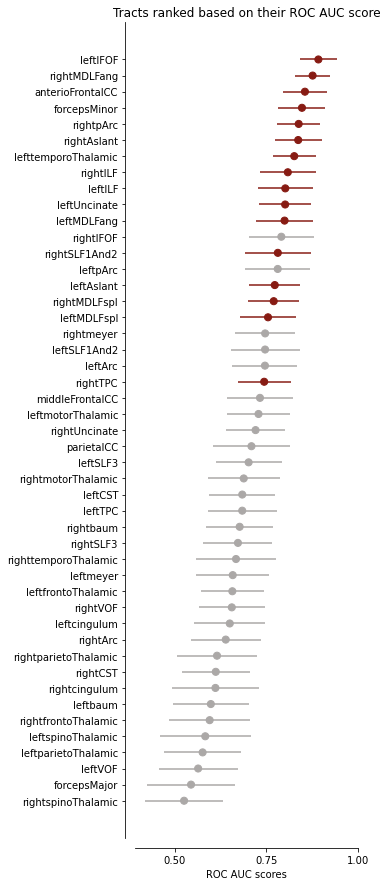

In [22]:
#correction with FDR
ranking = np.argsort(np.argsort(p_list))
p_fdr_corrected = p_list * (ranking+1) / n_tracts
p_th = 0.001
plt.rcParams['svg.fonttype'] = 'none'

auc_list = [v[1] for k,v in auc_dict.items()]
idx_ordered = np.flip(np.argsort(auc_list))
p_fdr_corrected_ordered = p_fdr_corrected[idx_ordered]

color_list = []
significant_tracts_auc = []
for p, p_fdr in enumerate(p_fdr_corrected_ordered):
    if p_fdr < p_th:
        color_list.append('#871b13') #dark red
        significant_tracts_auc.append(tract_name_list_ordered[p]) 
    else:
        color_list.append('#aba8a7') #grey
        
y_pos = np.arange(len(tract_name_list_ordered))

fig = plt.figure(figsize=(4,15))
ax = fig.add_subplot(1,1,1)
plt.scatter(auc_ordered, y_pos, color=color_list, s=50)
plt.errorbar(auc_ordered, y_pos, xerr=auc_ordered_std, fmt='none', ecolor=color_list)
plt.yticks(y_pos, tract_name_list_ordered)
plt.xticks([0.5,0.75,1],["0.50","0.75","1.00"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('ROC AUC scores')
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(("outward", 10))
ax.spines['left'].set_position(("outward", 10))
plt.title("Tracts ranked based on their ROC AUC score")

plt.savefig('auc_ordered_0001_dot_plot_fdr.svg', bbox_inches = "tight")
plt.savefig('auc_ordered_0001_dot_plot_fdr.png', bbox_inches = "tight")
plt.show()        

In [23]:
significant_tracts_auc

['leftIFOF',
 'rightMDLFang',
 'anterioFrontalCC',
 'forcepsMinor',
 'rightpArc',
 'rightAslant',
 'lefttemporoThalamic',
 'rightILF',
 'leftILF',
 'leftUncinate',
 'leftMDLFang',
 'rightSLF1And2',
 'leftAslant',
 'rightMDLFspl',
 'leftMDLFspl',
 'rightTPC']

In [24]:
#write to df and then to csv
mean_profiles_early2D = np.mean(fa_profiles_early[:,10:90,:], axis=1)
mean_profiles_late2D = np.mean(fa_profiles_late[:,10:90,:], axis=1)
mean_profiles2D = np.hstack((mean_profiles_early2D, mean_profiles_late2D))
sub_early = []
sub_late = []
for s, sub in enumerate(sub_list):
    if rtp.loc[int(sub), 'rtpLabel'] == 0:
        sub_early.append(sub)
    elif rtp.loc[int(sub), 'rtpLabel'] == 1:
        sub_late.append(sub)
sub_sorted = np.concatenate((sub_early,sub_late))
df = pd.DataFrame(mean_profiles2D, index=tract_name_list_sorted, columns=sub_sorted)
df.to_csv('mean_FA_47tracts_51subjects.csv')
df

,496,2236,384,1833,869,3159,1062,3028,2844,388,...,1133,3320,3214,1386,3508,3318,2417,3468,2827,3283
anterioFrontalCC,0.632962,0.568857,0.626708,0.586930,0.647476,0.558272,0.611070,0.613666,0.596724,0.592404,...,0.618450,0.522183,0.572471,0.593135,0.564249,0.558280,0.578814,0.560978,0.575504,0.605542
forcepsMajor,0.737866,0.703005,0.726527,0.649913,0.727517,0.670481,0.731945,0.712419,0.668552,0.745050,...,0.729845,0.706121,0.713530,0.743247,0.682015,0.646550,0.679819,0.640497,0.710944,0.742961
forcepsMinor,0.634883,0.568031,0.614243,0.594077,0.637367,0.525520,0.609092,0.617113,0.612825,0.606365,...,0.586327,0.523520,0.575104,0.559238,0.543411,0.563934,0.565215,0.583736,0.595425,0.611458
leftArc,0.502215,0.477428,0.500105,0.439583,0.510844,0.438035,0.487041,0.525188,0.428255,0.476431,...,0.486667,0.512238,0.434677,0.463121,0.471023,0.433315,0.508143,0.442485,0.405755,0.453436
leftAslant,0.521281,0.476480,0.523383,0.498224,0.507089,0.480618,0.503857,0.510420,0.450239,0.504245,...,0.509887,0.482438,0.496723,0.468858,0.487647,0.458130,0.464183,0.462430,0.441417,0.474729
leftCST,0.619819,0.544799,0.551569,0.513205,0.562571,0.532348,0.553419,0.547949,0.516649,0.535549,...,0.534919,0.564440,0.537515,0.506347,0.534269,0.494520,0.533043,0.511952,0.502608,0.515970
leftIFOF,0.648689,0.550403,0.596144,0.538804,0.586132,0.552703,0.583771,0.580068,0.555473,0.575036,...,0.580563,0.510105,0.537848,0.548568,0.543881,0.509848,0.564490,0.552247,0.528649,0.541580
leftILF,0.621294,0.543618,0.567127,0.517455,0.547759,0.506661,0.553562,0.576472,0.540783,0.548752,...,0.552556,0.503419,0.514416,0.526304,0.515612,0.513831,0.557653,0.533459,0.510328,0.544438
leftMDLFang,0.561366,0.510192,0.477017,0.448813,0.486940,0.471275,0.496898,0.546665,0.485606,0.492897,...,0.514935,0.474190,0.439074,0.431042,0.444833,0.430672,0.484571,0.486118,0.470765,0.503819
leftMDLFspl,0.546876,0.502970,0.487837,0.453242,0.483129,0.507498,0.496891,0.531611,0.479668,0.504560,...,0.524634,0.489771,0.449449,0.470799,0.458693,0.476917,0.505418,0.458222,0.473539,0.497493
